## Caso de estudio 2.

Importamos las librerías necesarias

In [380]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, MeanShift, DBSCAN, Birch, AgglomerativeClustering, estimate_bandwidth
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from math import floor

import seaborn as sns

In [381]:
def imputar_vacios(df):
    return df.fillna(df.mean())

In [382]:
def filtrar_valores(df):
    return df[(df["Type"] == "hotel") & (df["Quality"] >= 4) & (df["Rating"] != 0) & (df["Distance"] <= 10000)]

In [383]:
def norm_to_zero_one(df): # Normalizar datos
    """Normaliza un DataFrame entre 0 y 1, devuelve los datos normalizados junto con los mínimos y máximos."""
    min_vals = df.min()
    max_vals = df.max()
    norm_data = (df - min_vals) / (max_vals - min_vals)
    return norm_data, min_vals, max_vals

In [384]:
def denorm_from_zero_one(norm_data, min_vals, max_vals): # Función para desnormalizar datos
    """Desnormaliza un DataFrame desde 0-1 usando los valores mínimos y máximos."""
    denorm_data = norm_data * (max_vals - min_vals) + min_vals
    return denorm_data

In [385]:
def gen_heatmap(centers_desnormal):
    centers = (centers_desnormal - centers_desnormal.min()) / (
        centers_desnormal.max() - centers_desnormal.min()
    )
    
    plt.figure()
    centers.index += 1
    plt.figure()
    hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
    hm.set_ylim(len(centers),0)
    hm.figure.set_size_inches(15,15)
    centers.index -= 1

In [386]:
def gen_heatmap_2(data, labels, method="mean"):

    # Crear un DataFrame con etiquetas de clusters
    data_with_labels = data.copy()
    data_with_labels["cluster"] = labels

    # Filtrar puntos que no son ruido (-1)
    data_clusters = data_with_labels[data_with_labels["cluster"] != -1]

    # Calcular resumen (media o mediana) de cada variable por cluster
    if method == "mean":
        cluster_summary = data_clusters.groupby("cluster").mean()
    elif method == "median":
        cluster_summary = data_clusters.groupby("cluster").median()
    else:
        raise ValueError("El método debe ser 'mean' o 'median'.")

    # Desnormalizar los datos para anotaciones
    cluster_summary_denorm = denorm_from_zero_one(cluster_summary, min_vals, max_vals)

    # Generar el heatmap
    plt.figure()
    cluster_summary.index += 1  # Ajustar índices para que empiecen en 1
    plt.figure()
    hm = sns.heatmap(cluster_summary, cmap="YlGnBu", annot=cluster_summary_denorm, fmt='.3f', annot_kws={"fontsize":18})
    hm.set_ylim(len(cluster_summary), 0)
    hm.figure.set_size_inches(15,15)
    cluster_summary.index -= 1

In [387]:
def gen_pairplot(df): # Generar un pairplot
    plt.figure()
    sns.set()
    variables = list(df)
    variables.remove("Cluster")
    df["Cluster"] += 1
    sns_plot = sns.pairplot(df, 
                            vars=variables, 
                            hue="Cluster", 
                            palette="pastel", 
                            plot_kws={"s": 25}, 
                            diag_kind="hist")
    
    df["Cluster"] -= 1
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03)
    sns_plot.fig.set_size_inches(15,15)
    plt.show()

In [388]:
def gen_dendogram(df):
    Z = linkage(df, method='single')
    
    plt.figure(figsize=(12, 8))
    dendrogram(
        Z,
        orientation="left",                    # Rotar para tener el estilo horizontal
        truncate_mode="lastp",  # Mostrar solo los últimos clusters fusionados
        p=10,
        leaf_rotation=0,                        # Rotación de las etiquetas
        leaf_font_size=10,                      # Tamaño de la fuente de las etiquetas
        show_contracted=True                    # Mostrar contracción de clusters
    )

    plt.title("Dendrograma con Enlace Simple", fontsize=16)
    plt.xlabel("Distancia")
    plt.ylabel("Índice de Muestra")
    plt.tight_layout() 
    plt.show()

In [389]:
def gen_boxplot(data, clusters):
    # Agregar los clusters como columna al DataFrame
    data_with_clusters = data.copy()
    
    # Configurar estilo de Seaborn
    sns.set(style="darkgrid", palette="muted", font_scale=1)

    # Identificar las variables numéricas
    variables = data.columns[:-1]
    n_clusters = len(set(clusters))
    n_rows = n_clusters
    n_cols = len(variables)

    # Calcular los rangos globales de cada variable
    variable_ranges = {var: (data[var].min(), data[var].max()) for var in variables}

    # Crear subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharey='row')

    # Asegurarse de que axes sea un arreglo bidimensional
    if n_clusters == 1:
        axes = [axes]  # Caso con un solo cluster
    if n_cols == 1:
        axes = [[ax] for ax in axes]  # Caso con una sola variable

    # Generar boxplots para cada cluster y variable con ejes uniformes
    for i, cluster in enumerate(sorted(data_with_clusters['Cluster'].unique())):
        cluster_data = data_with_clusters[data_with_clusters['Cluster'] == cluster]
        for j, variable in enumerate(variables):
            sns.boxplot(
                x=cluster_data[variable],
                ax=axes[i][j],
                color=sns.color_palette("muted")[i % len(sns.color_palette("muted"))]
            )
            axes[i][j].set(title=variable, ylabel=f"Cluster {cluster}")
            axes[i][j].set(xlabel="")
            # Fijar el rango global en el eje X para cada variable
            axes[i][j].set_xlim(variable_ranges[variable])

    # Ajustar diseño
    fig.tight_layout()
    fig.suptitle("Boxplots por Clusters y Variables (Rango Uniforme)", fontsize=16, y=1.02)
    plt.show()

In [390]:
def generar_metricas(df, clusters):
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    muestra_silhouette = 0.2 if (len(df) > 10000) else 1.0
    print("Silhouette")
    silhouette = silhouette_score(df, clusters, metric='euclidean', sample_size=floor(muestra_silhouette*len(df)), random_state=123456) if len(set(clusters)) > 1 else np.nan
    print("Calinski_harabasz")
    calinski_harabasz = calinski_harabasz_score(df, clusters) if len(set(clusters)) > 1 else np.nan
    print("Davies_Bouldin")
    davies_bouldin = davies_bouldin_score(df, clusters) if len(set(clusters)) > 1 else np.nan
    return n_clusters, silhouette, calinski_harabasz, davies_bouldin

In [391]:
def barras_clusters(clusters):
    clusters, counts = np.unique(clusters, return_counts=True)
    cluster_counts = pd.DataFrame({'Cluster': clusters, 'Count': counts}).sort_values(by="Cluster")
    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_counts['Cluster'], cluster_counts['Count'], color="skyblue", edgecolor="skyblue")
    plt.xticks(cluster_counts['Cluster'], labels=[f"Cluster {int(c)}" for c in cluster_counts['Cluster']])
    plt.xlabel("Clusters", fontsize=12)
    plt.ylabel("Cantidad de Datos", fontsize=12)
    plt.title("Distribución de Datos por Cluster", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Conseguimos los datos del CSV

In [392]:
datos = pd.read_csv('booking_Granada_2024.csv',sep= ';', encoding="iso-8859-1")
print(datos.describe())

       Ranking position          Price       Distance        Quality  \
count     194497.000000  194497.000000  194497.000000  194497.000000   
mean         179.353532     560.261644    1740.587156       3.119174   
std          106.895507     472.297035    5209.808647       1.150540   
min            1.000000      53.000000      20.000000       0.000000   
25%           87.000000     287.000000     350.000000       3.000000   
50%          175.000000     453.000000     600.000000       3.000000   
75%          269.000000     689.000000    1000.000000       4.000000   
max          400.000000   22255.000000   59300.000000       5.000000   

              Rating         Review       Bedrooms   Living Rooms  \
count  194497.000000  194497.000000  194497.000000  194497.000000   
mean        8.382349     223.184908       1.879263       0.514964   
std         1.839324     267.591125       1.520893       0.499777   
min         0.000000       0.000000       0.000000       0.000000   
25%   

Comprobamos si las variables tienen valores vacíos.

In [393]:
# Contar los valores vacíos (nulos) para cada variable
valores_vacios = datos.isnull().sum()
print(valores_vacios)

Ranking position               0
Hotel name                     0
Price                          0
Deal                      164636
Location                       0
Distance                       0
Type                       17506
Quality                        0
Rating                         0
Special                    98718
Review                         0
Description                    0
Bedrooms                       0
Living Rooms                   0
Bathrooms                      0
Kitchens                       0
Surface Area (m2)              0
Total Beds                     0
Individual Beds                0
Double Beds                    0
Double Large Beds              0
Double Extralarge Beds         0
Sofa Beds                      0
Bunk Beds                      0
Search in advance              0
Guests                         0
Average selected price         0
Total of apartments            0
Total of hotels                0
Query date                     0
Check in  

Imputamos valores perdidos y nos quedamos con los datos que cumplan las condiciones específicas del caso de estudio

In [394]:
datos_filtrados = filtrar_valores(datos)
print(datos_filtrados.describe())

       Ranking position         Price      Distance       Quality  \
count      13108.000000  13108.000000  13108.000000  13108.000000   
mean         220.514876    970.716433   1059.527006      4.165777   
std          104.285092    966.977119    987.411567      0.371894   
min            1.000000     94.000000     20.000000      4.000000   
25%          138.000000    404.000000    400.000000      4.000000   
50%          236.000000    710.000000    800.000000      4.000000   
75%          313.000000   1192.000000   1300.000000      4.000000   
max          400.000000  16892.000000   6300.000000      5.000000   

             Rating        Review      Bedrooms  Living Rooms     Bathrooms  \
count  13108.000000  13108.000000  13108.000000  13108.000000  13108.000000   
mean       8.596773    478.724977      0.179127      0.071254      0.137473   
std        0.446487    287.669808      0.569929      0.257259      0.459073   
min        7.500000     11.000000      0.000000      0.000000 

In [395]:
usadas_cluster = ["Rating", "Price", "Distance", "Guests"]
datos_imputados = imputar_vacios(datos_filtrados[usadas_cluster])
print(datos_imputados.describe())

             Rating         Price      Distance        Guests
count  13108.000000  13108.000000  13108.000000  13108.000000
mean       8.596773    970.716433   1059.527006      6.116417
std        0.446487    966.977119    987.411567      2.360284
min        7.500000     94.000000     20.000000      2.000000
25%        8.400000    404.000000    400.000000      4.000000
50%        8.600000    710.000000    800.000000      8.000000
75%        8.800000   1192.000000   1300.000000      8.000000
max        9.600000  16892.000000   6300.000000      8.000000


Volvemos a comprobar si tras el filtrado hay valores vacíos

In [396]:
valores_vacios2 = datos_imputados.isnull().sum()
print(valores_vacios2)

Rating      0
Price       0
Distance    0
Guests      0
dtype: int64


Normalizamos los datos y guardamos los valores mínimos y máximos para luego poder desnormalizarlos

In [397]:
X, min_vals, max_vals = norm_to_zero_one(datos_imputados)
print(X.describe())

             Rating         Price      Distance        Guests
count  13108.000000  13108.000000  13108.000000  13108.000000
mean       0.522273      0.052192      0.165530      0.686070
std        0.212613      0.057565      0.157231      0.393381
min        0.000000      0.000000      0.000000      0.000000
25%        0.428571      0.018455      0.060510      0.333333
50%        0.523810      0.036671      0.124204      1.000000
75%        0.619048      0.065365      0.203822      1.000000
max        1.000000      1.000000      1.000000      1.000000


In [398]:
results = []

## K-means

In [109]:
print("Ejecutando KMeans")
X_km = X
# Evaluate each algorithm
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=5, random_state=123456)
start_time = time.time()
clusters_km = kmeans.fit_predict(X_km)
end_time = time.time()

print("Obteniendo métricas")

n, silh, ch, db = generar_metricas(X_km, clusters_km)

results.append({
    "Algorithm": "KMeans",
    "Number of Clusters": n,
    "Execution Time (s)": end_time - start_time,
    "Silhouette Score": silh,
    "Calinski-Harabasz Index": ch,
    "Davies-Bouldin Index": db
})

Ejecutando KMeans
Obteniendo métricas
Silhouette
Calinski_harabasz
Davies_Bouldin


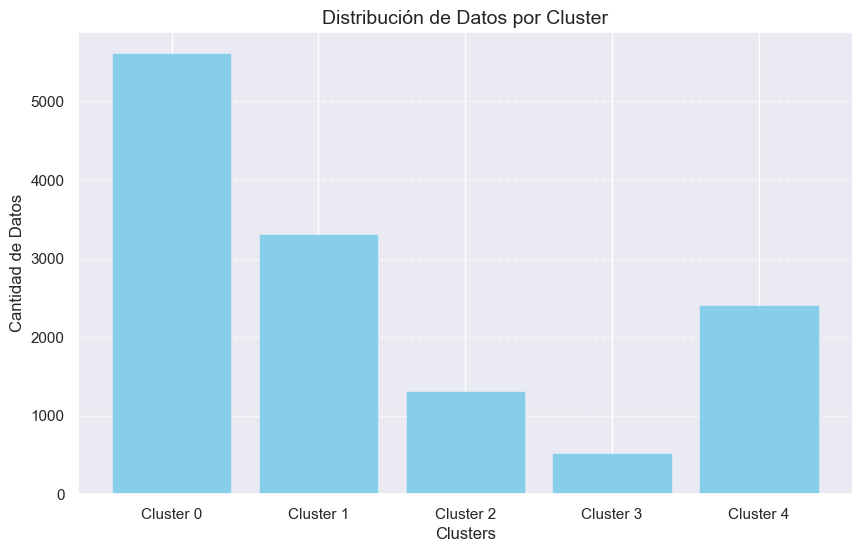

Tamaño de cada cluster:
0:  5600 (42.72%)
1:  3300 (25.18%)
2:  1296 ( 9.89%)
3:   510 ( 3.89%)
4:  2402 (18.32%)


In [110]:
barras_clusters(clusters_km)

clusters_dataframe_km = pd.DataFrame(clusters_km,index=X_km.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters_dataframe_km['cluster'].value_counts()
size = size.sort_index()

for i,c in enumerate(size):
   print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters_dataframe_km)))

In [111]:
# Print results as a table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

Algorithm  Number of Clusters  Execution Time (s)  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
   KMeans                   5            0.038693           0.44467             11470.518383              0.918898


#### HEATMAP KMEANS

<Figure size 640x480 with 0 Axes>

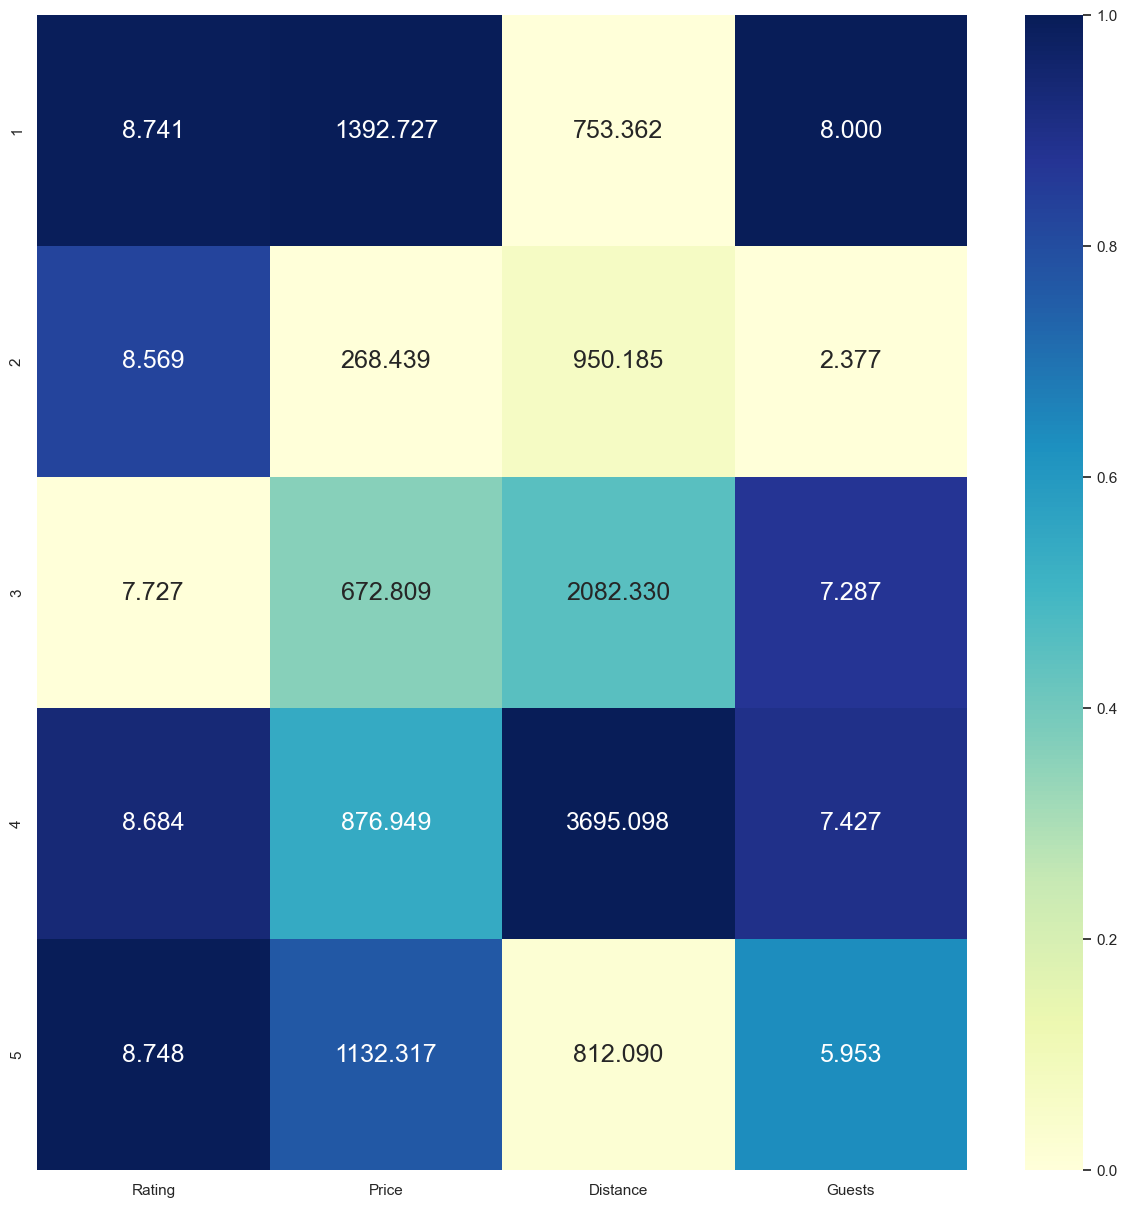

In [112]:
# Obtener los centros normalizados
centers_normalized_km = pd.DataFrame(kmeans.cluster_centers_, columns=list(X_km))
centers_desnormalized_km = denorm_from_zero_one(centers_normalized_km, min_vals, max_vals)
gen_heatmap(centers_desnormalized_km)

#### SCATTER MATRIX KMEANS

<Figure size 640x480 with 0 Axes>

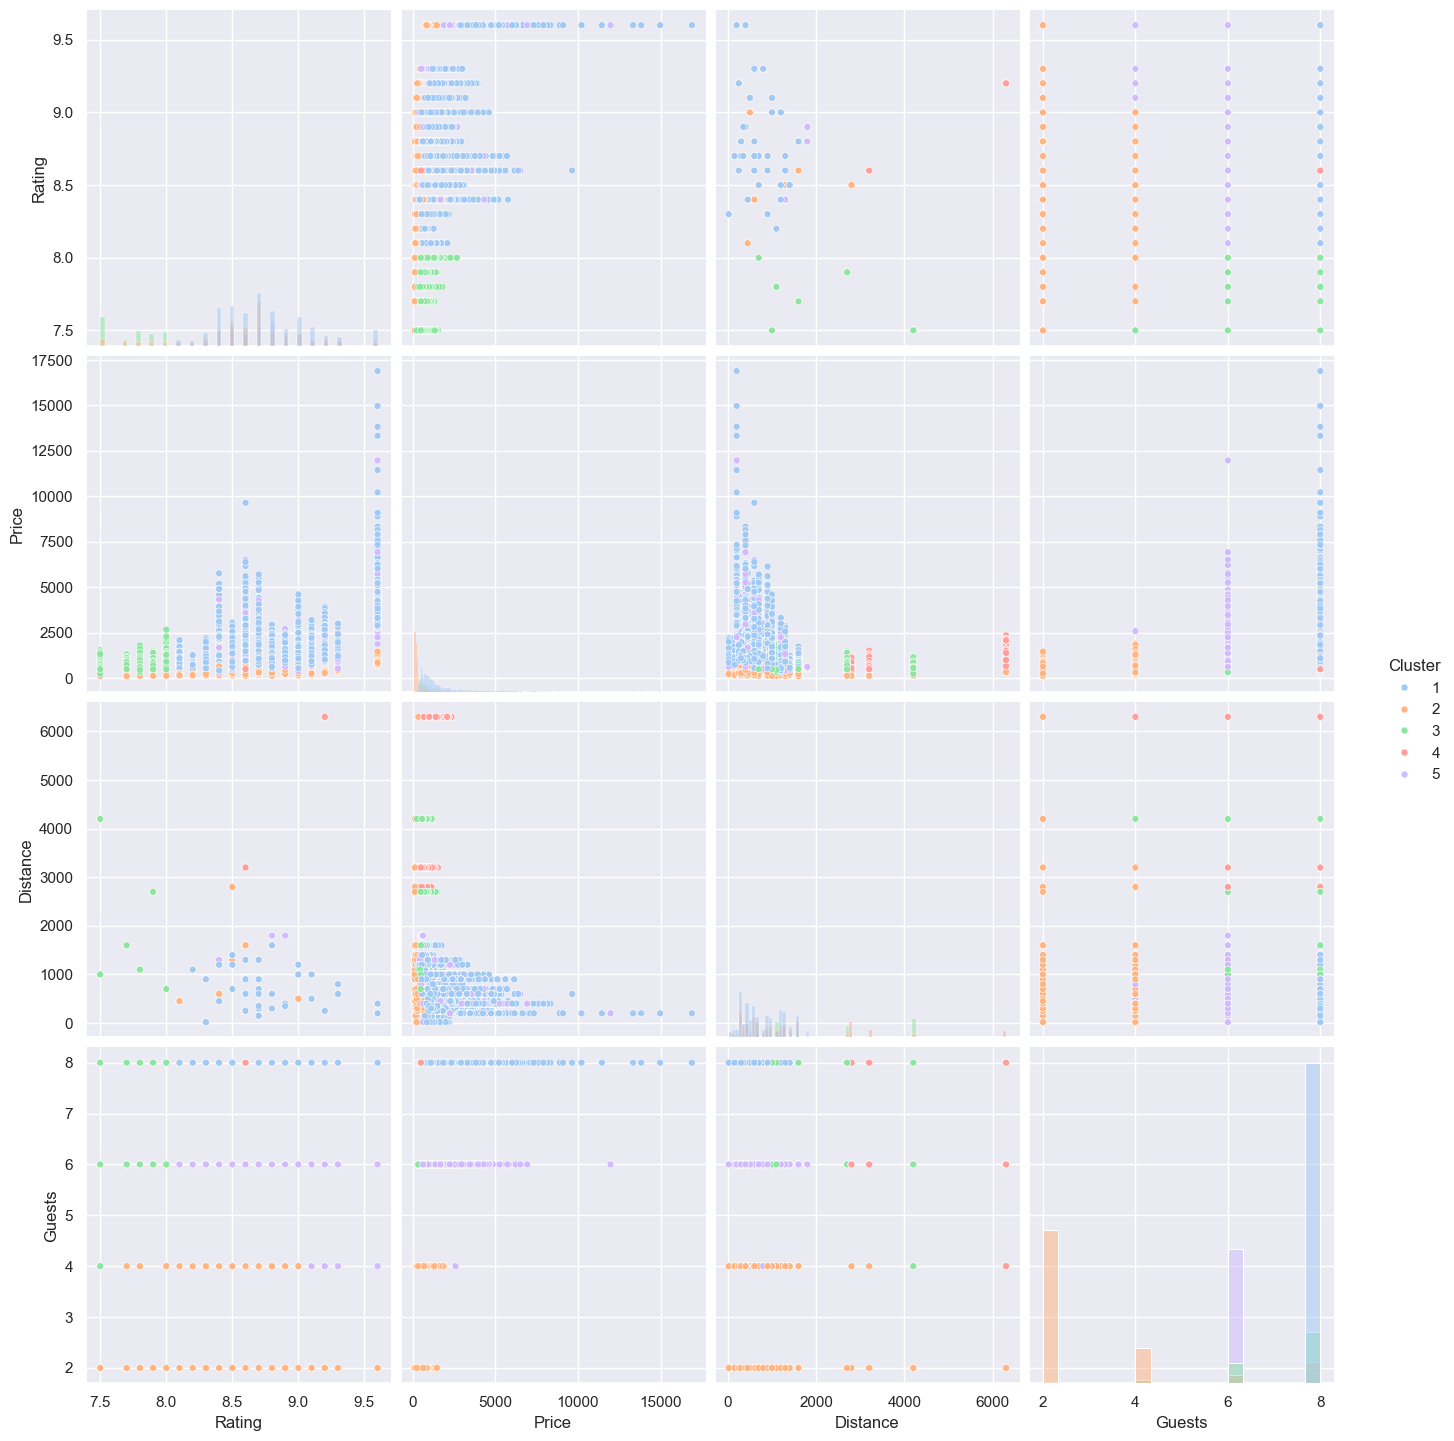

In [113]:
data_desnormalized = denorm_from_zero_one(X_km, min_vals, max_vals)
data_desnormalized['Cluster'] = clusters_km
gen_pairplot(data_desnormalized)

#### BOXPLOT

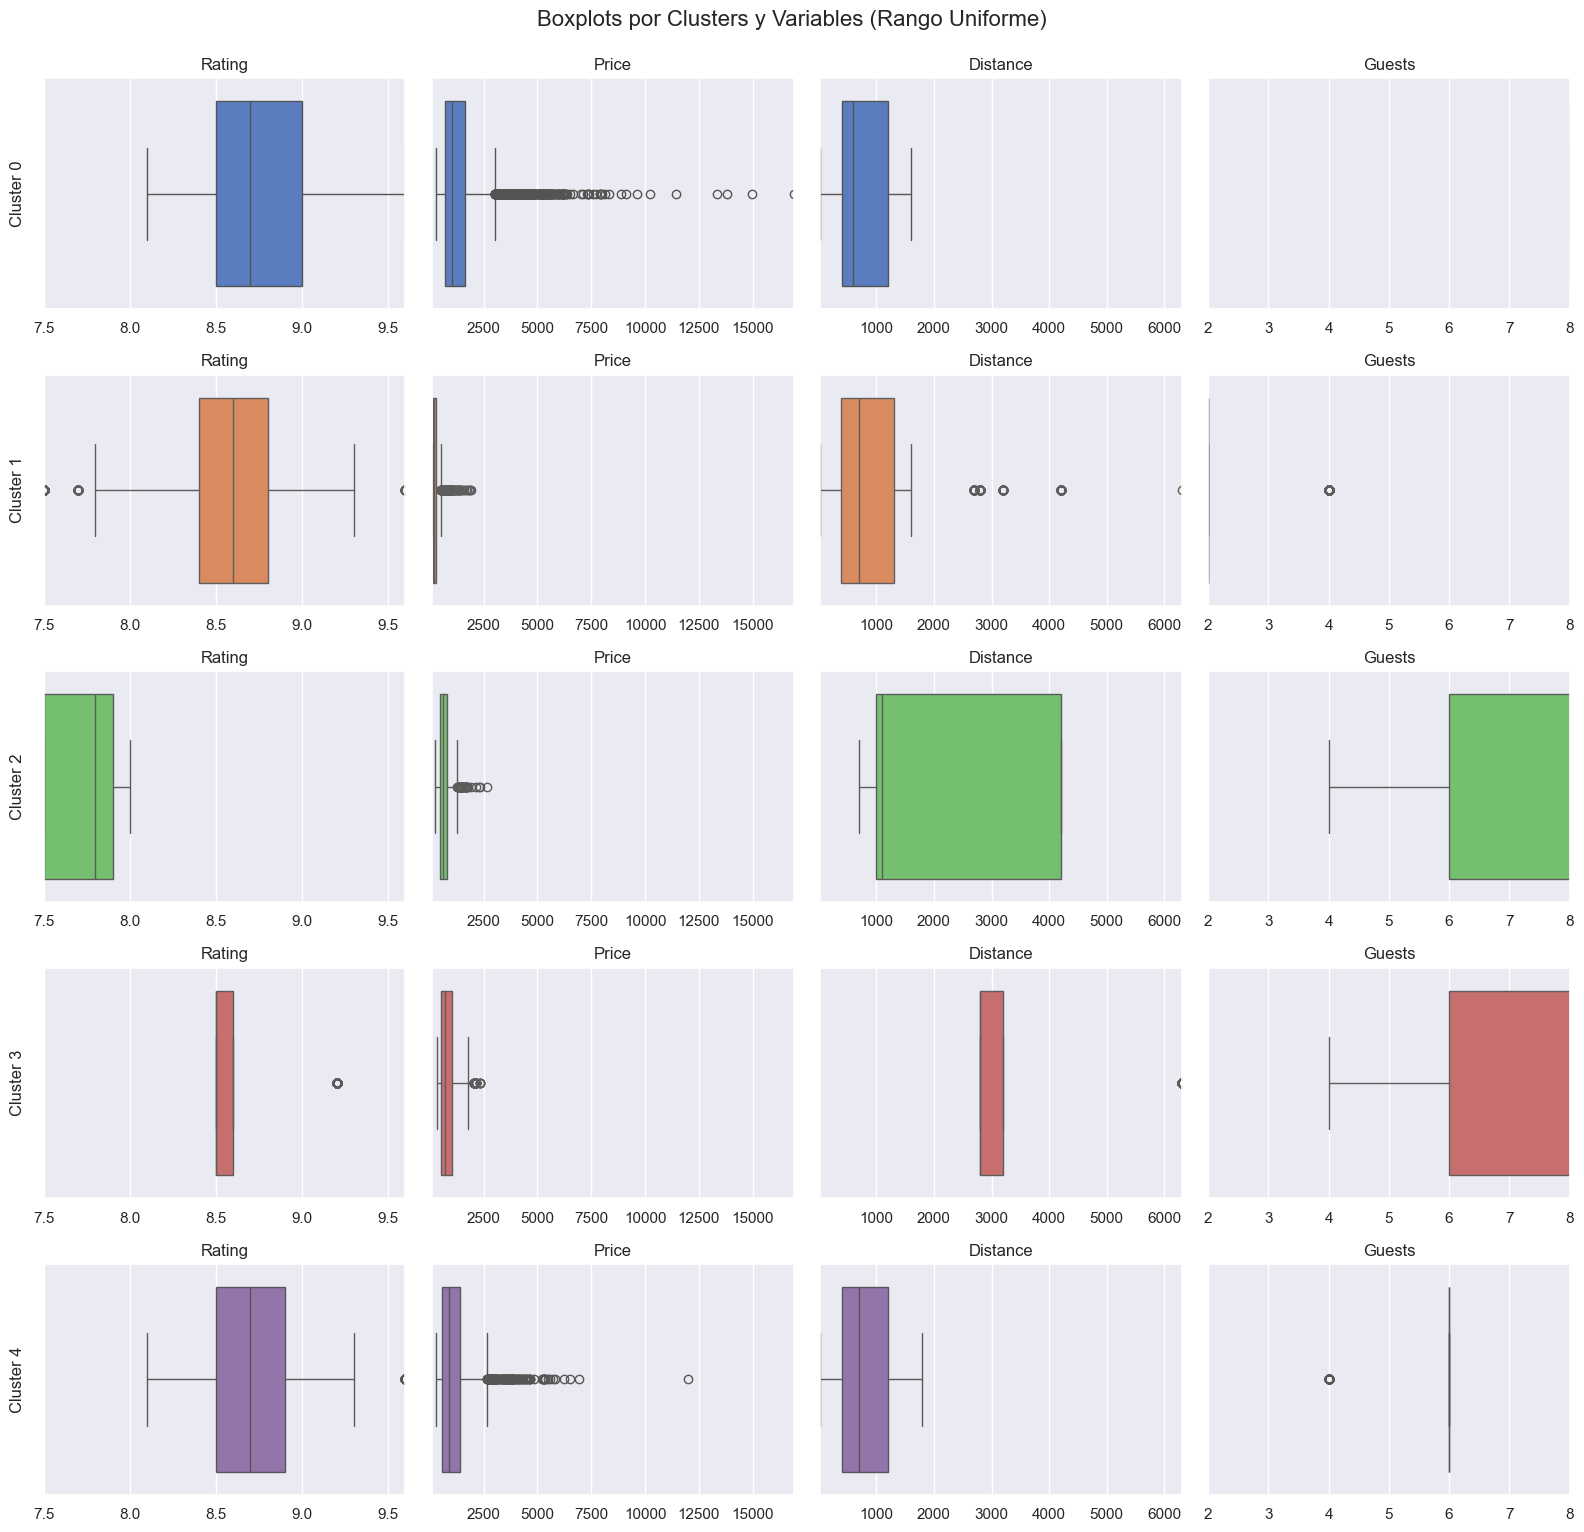

In [136]:
gen_boxplot(data_desnormalized, clusters_km)

## Mean Shift

In [114]:
X_meanshift = X

bandwidth = estimate_bandwidth(X, quantile=0.5, n_samples=100)
print(f"Bandwidth estimado: {bandwidth}")

meanshift = MeanShift(bandwidth = bandwidth, bin_seeding = True)
print("Ejecutando MeanShift")
start_time = time.time()
clusters_meanshift = meanshift.fit_predict(X)
end_time = time.time()

n, silh, ch, db = generar_metricas(X_meanshift, clusters_meanshift)

results.append({
    "Algorithm": "MeanShift",
    "Number of Clusters": n,
    "Execution Time (s)": end_time - start_time,
    "Silhouette Score": silh,
    "Calinski-Harabasz Index": ch,
    "Davies-Bouldin Index": db
})

Bandwidth estimado: 0.5282389616671846
Ejecutando MeanShift
Silhouette
Calinski_harabasz
Davies_Bouldin


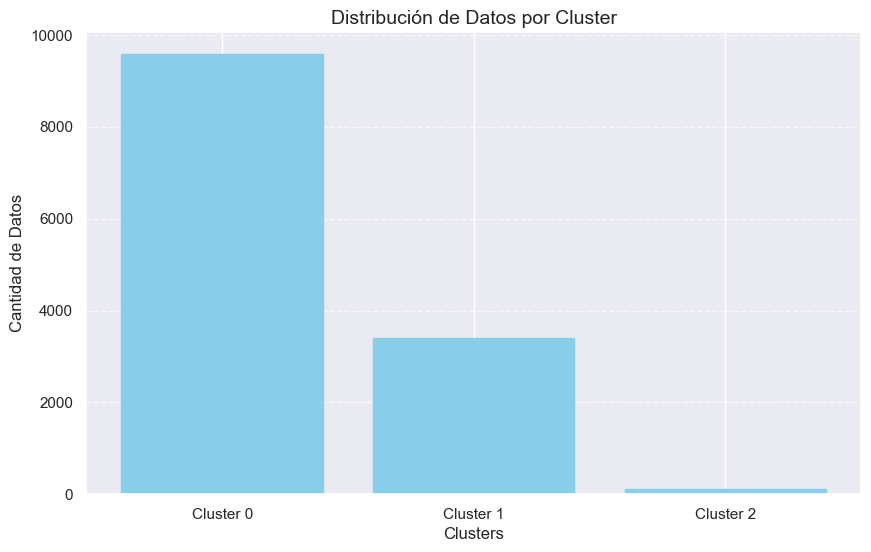

Tamaño de cada cluster:
0:  9582 (73.10%)
1:  3411 (26.02%)
2:   115 ( 0.88%)


In [115]:
barras_clusters(clusters_meanshift)

clusters_dataframe_meanshift = pd.DataFrame(clusters_meanshift,index=X_meanshift.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters_dataframe_meanshift['cluster'].value_counts()
size=size.sort_index()

for i,c in enumerate(size):
   print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters_dataframe_meanshift)))

In [116]:
# Print results as a table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

Algorithm  Number of Clusters  Execution Time (s)  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
   KMeans                   5            0.038693          0.444670             11470.518383              0.918898
MeanShift                   3            0.164572          0.570316             10498.861066              0.563672


#### HEATMAP MEAN SHIFT

<Figure size 640x480 with 0 Axes>

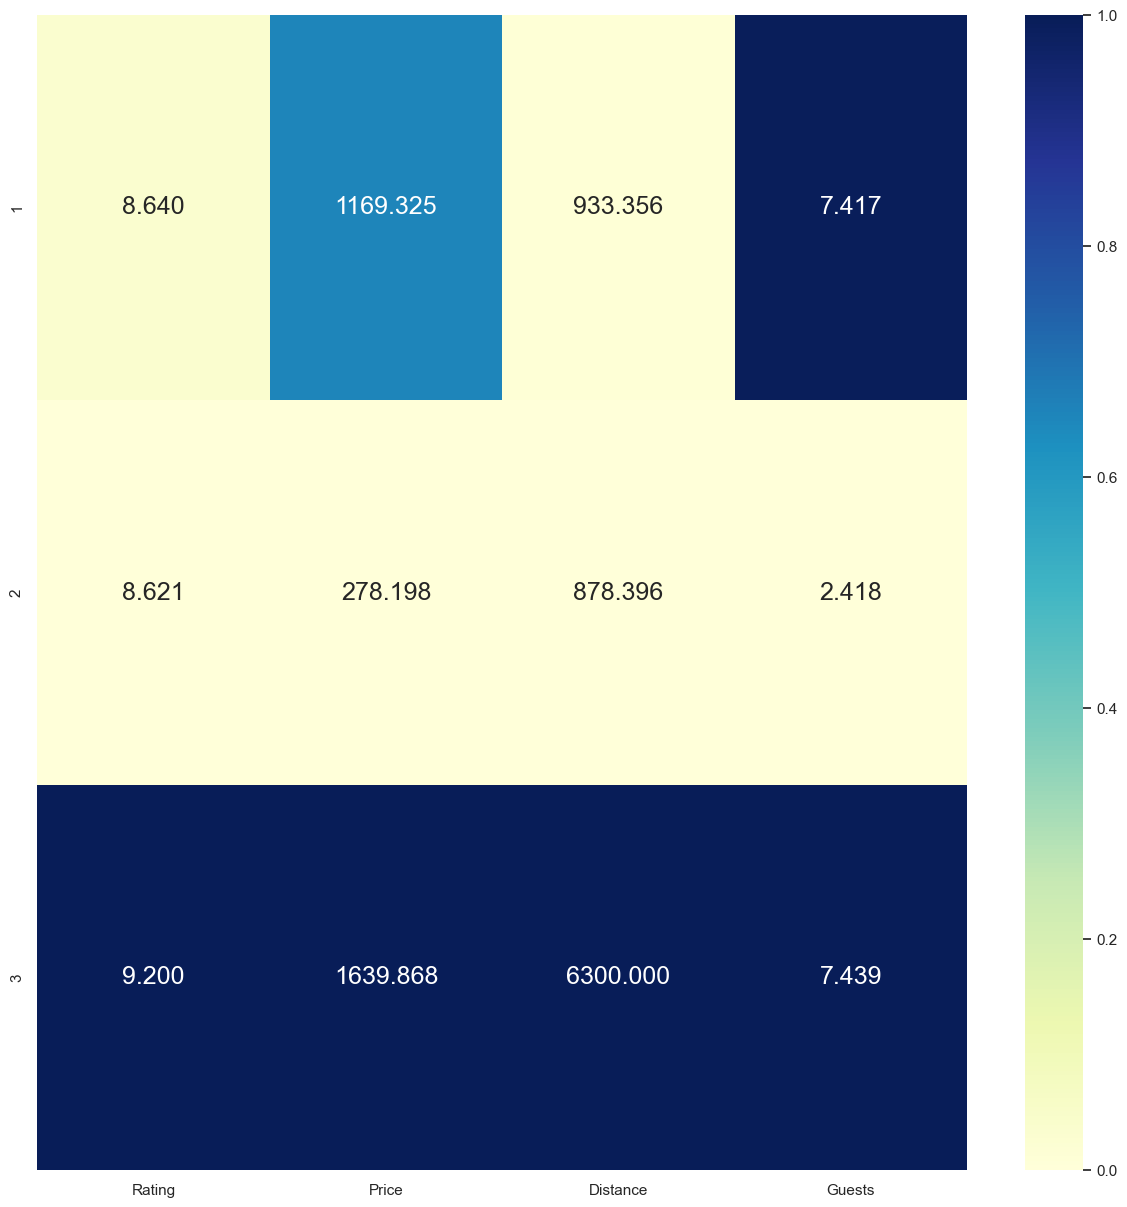

In [117]:
# Obtener los centros normalizados
centers_normalized_meanshift = pd.DataFrame(meanshift.cluster_centers_, columns=list(X_meanshift))
centers_desnormalized_meanshift = denorm_from_zero_one(centers_normalized_meanshift, min_vals, max_vals)
gen_heatmap(centers_desnormalized_meanshift)

#### SCATTER MATRIX MEANSHIFT

<Figure size 640x480 with 0 Axes>

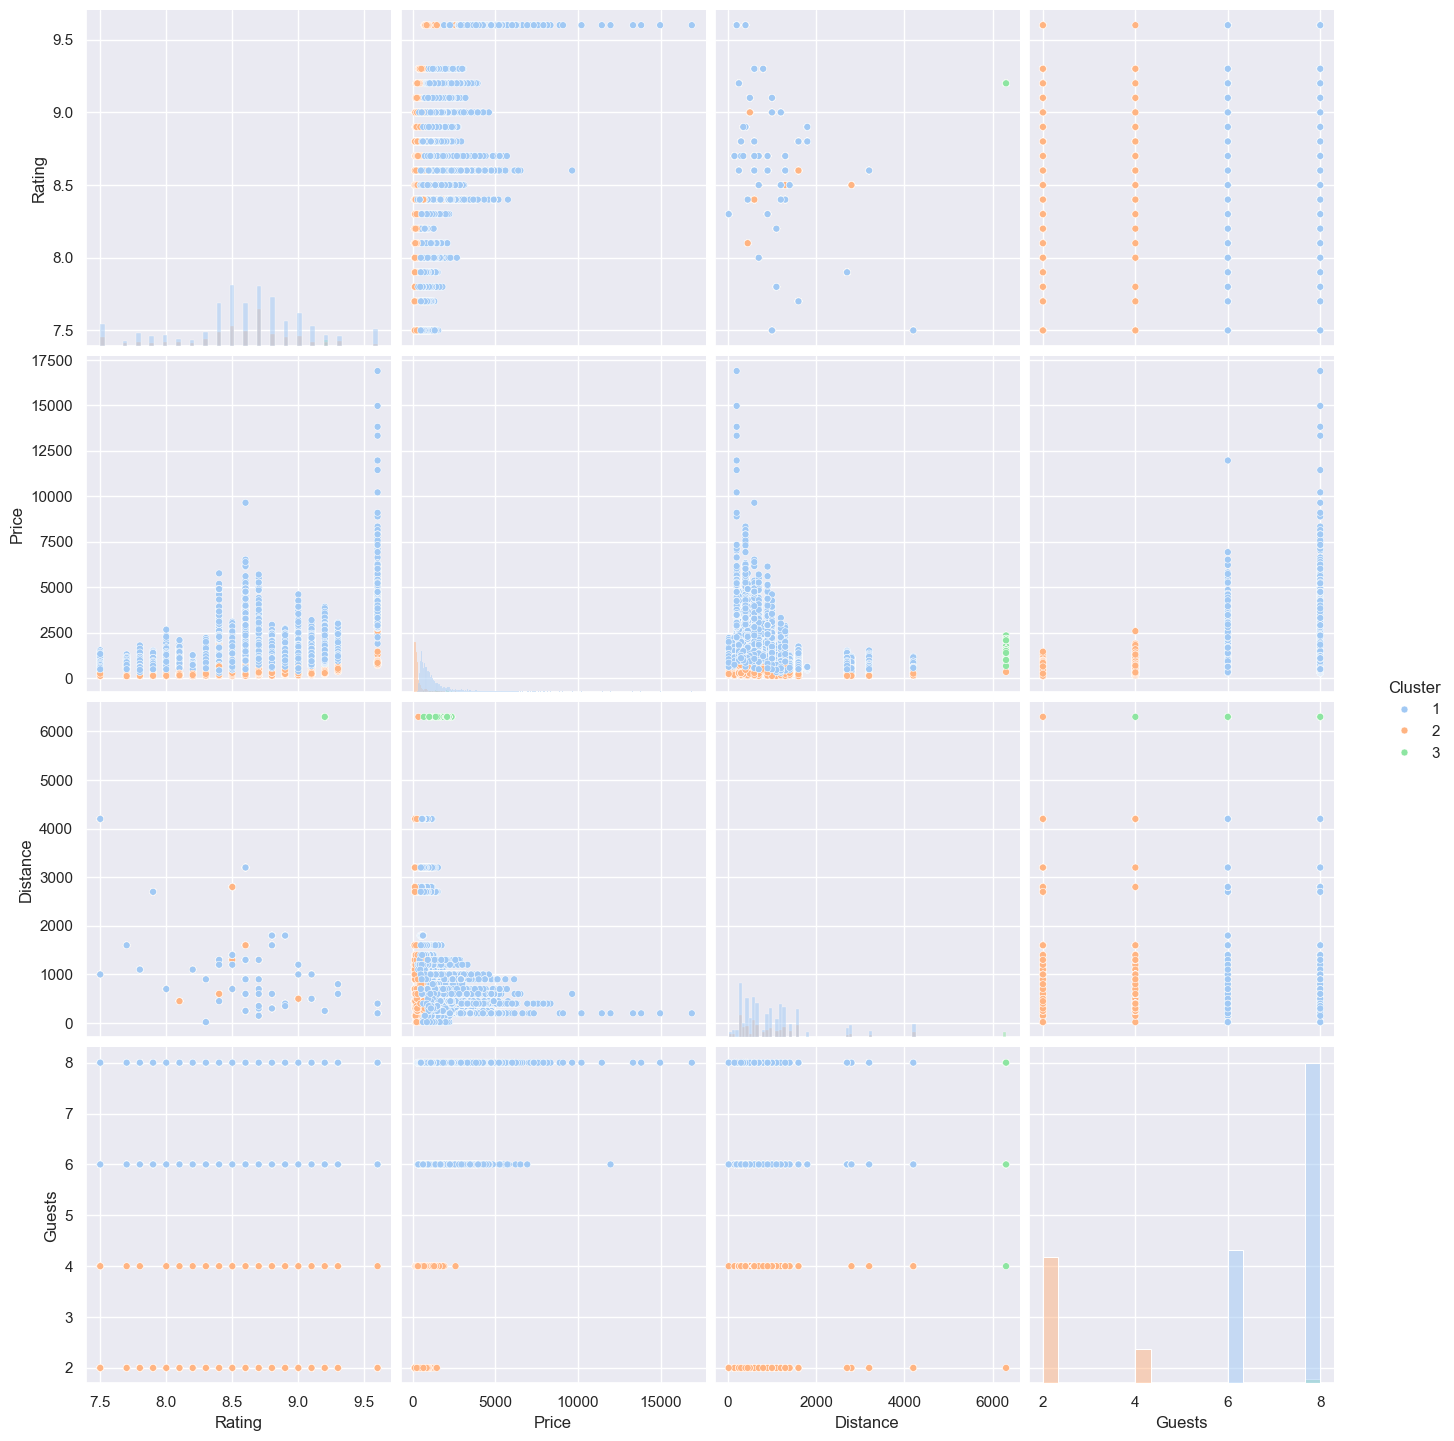

In [118]:
data_desnormalized_meanshift = denorm_from_zero_one(X_meanshift, min_vals, max_vals)
data_desnormalized_meanshift['Cluster'] = clusters_meanshift
gen_pairplot(data_desnormalized_meanshift)

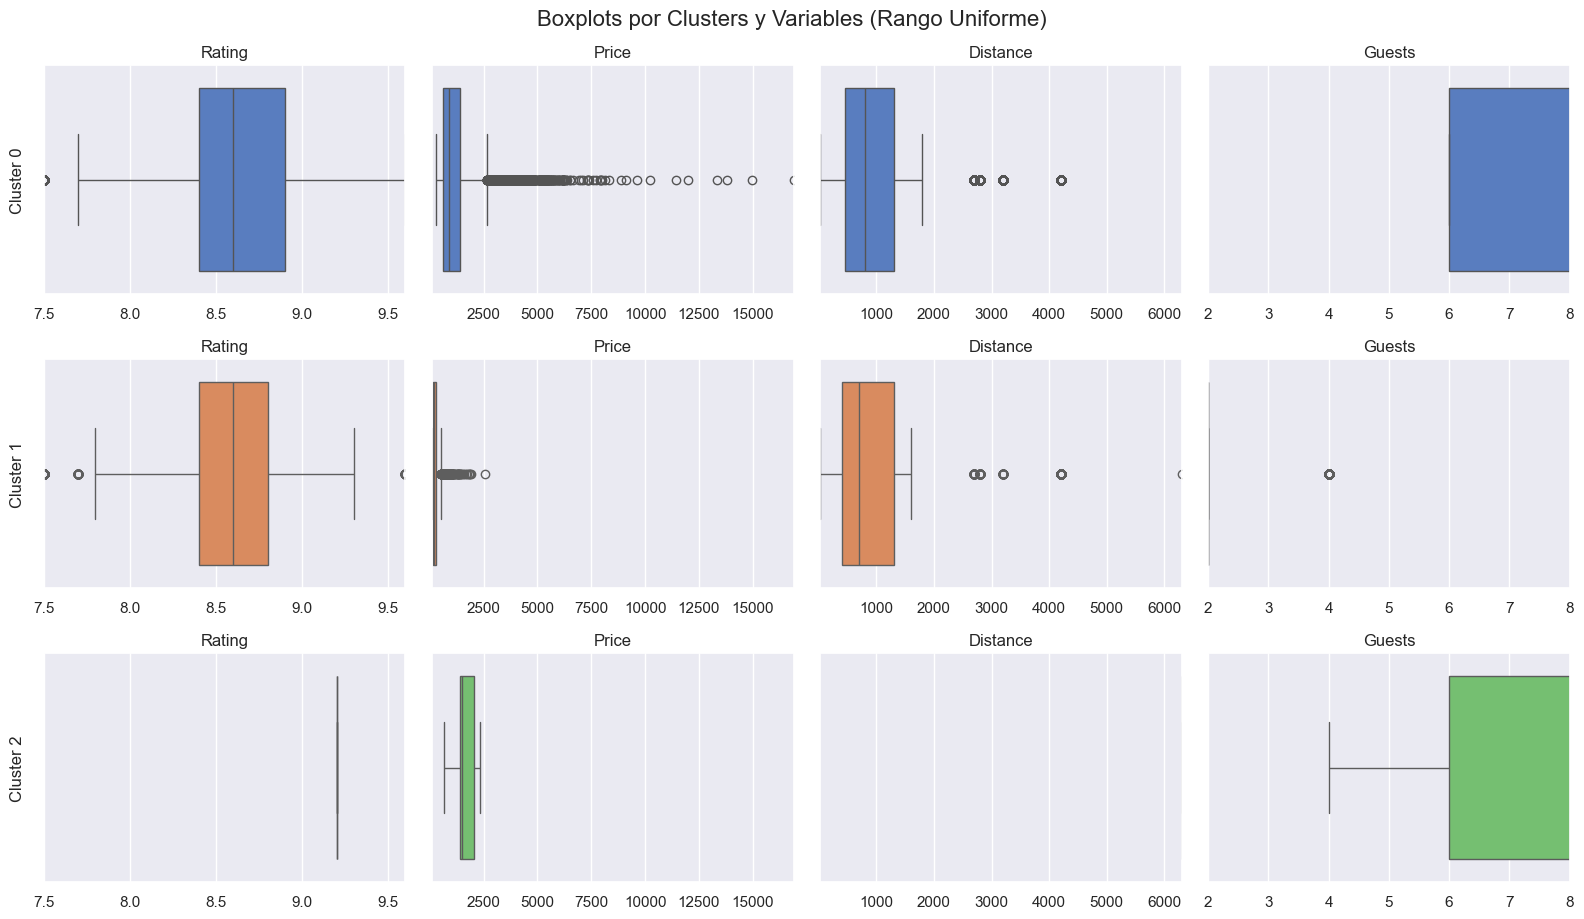

In [137]:
gen_boxplot(data_desnormalized_meanshift, clusters_meanshift)

## DBSCAN

In [196]:
X_dbscan = X

print("Ejecutando DBSCAN")
epsilon = 0.4
dbscan = DBSCAN(eps=epsilon, min_samples=10, algorithm="ball_tree", n_jobs=-1)
start_time = time.time()
clusters_dbscan = dbscan.fit_predict(X_dbscan)
end_time = time.time()

n, silh, ch, db = generar_metricas(X_dbscan, clusters_dbscan)

results.append({
    "Algorithm": "DBSCAN",
    "eps": epsilon,
    "Number of Clusters": n,
    "Execution Time (s)": end_time - start_time,
    "Silhouette Score": silh,
    "Calinski-Harabasz Index": ch,
    "Davies-Bouldin Index": db
})

Ejecutando DBSCAN
Silhouette
Calinski_harabasz
Davies_Bouldin


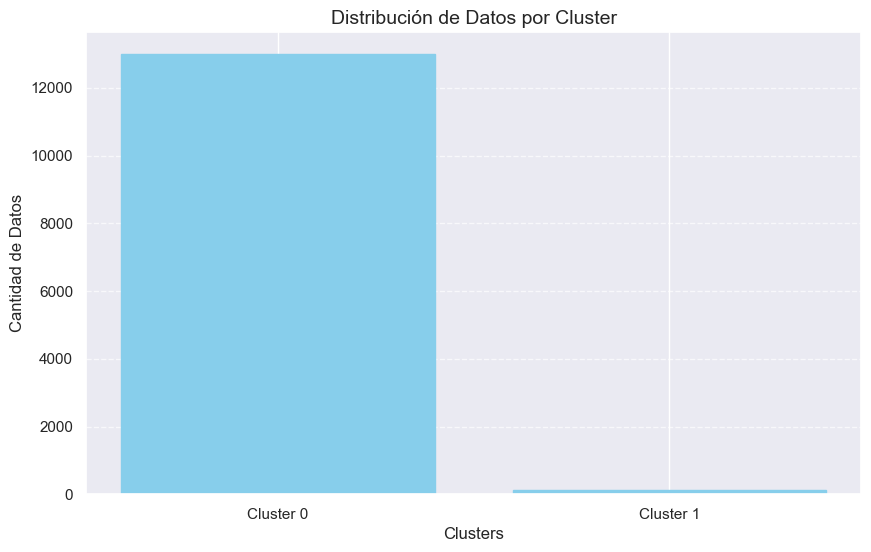

Tamaño de cada cluster:
0: 12992 (99.12%)
1:   116 ( 0.88%)


In [172]:
barras_clusters(clusters_dbscan)

clusters_df_dbscan = pd.DataFrame(clusters_dbscan,index=X_dbscan.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters_df_dbscan['cluster'].value_counts()
size = size.sort_index()

for i,c in enumerate(size):
   print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters_df_dbscan)))

In [197]:
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

Algorithm  eps  Number of Clusters  Execution Time (s)  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
   DBSCAN  0.2                  10            0.426065          0.396566              4775.456229              0.869403
   DBSCAN  0.3                  10            0.623387          0.396566              4768.082201              1.023428
   DBSCAN  0.4                   2            0.956989          0.444031               436.764486              0.631252


#### HEATMAP DBSCAN

<Figure size 640x480 with 0 Axes>

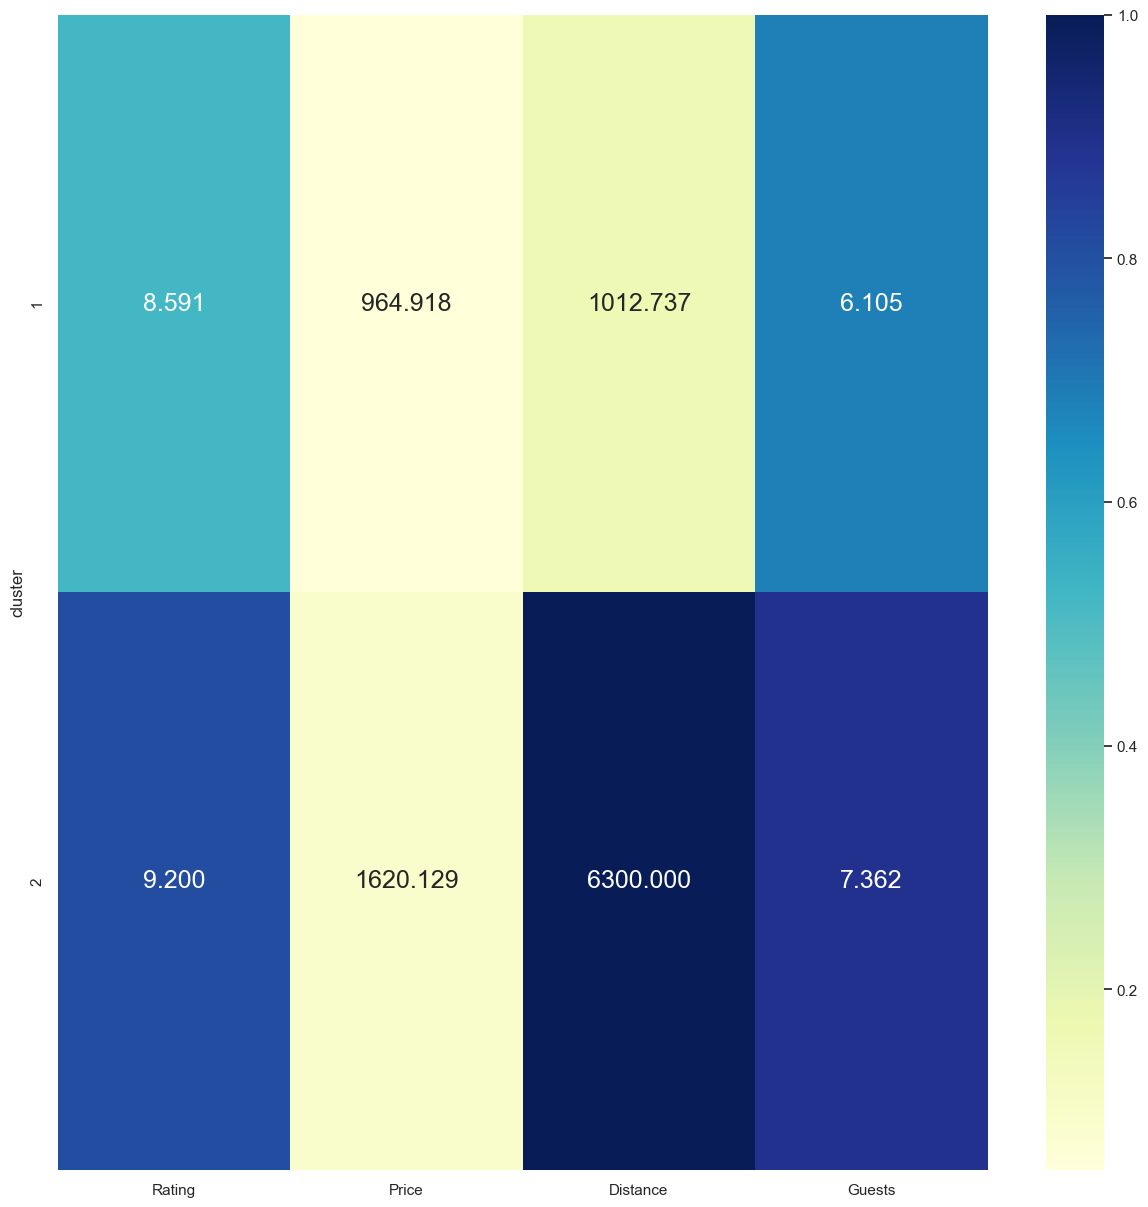

In [199]:
gen_heatmap_2(X_dbscan, clusters_dbscan, method="mean")

#### SCATTER MATRIX DBSCAN

<Figure size 640x480 with 0 Axes>

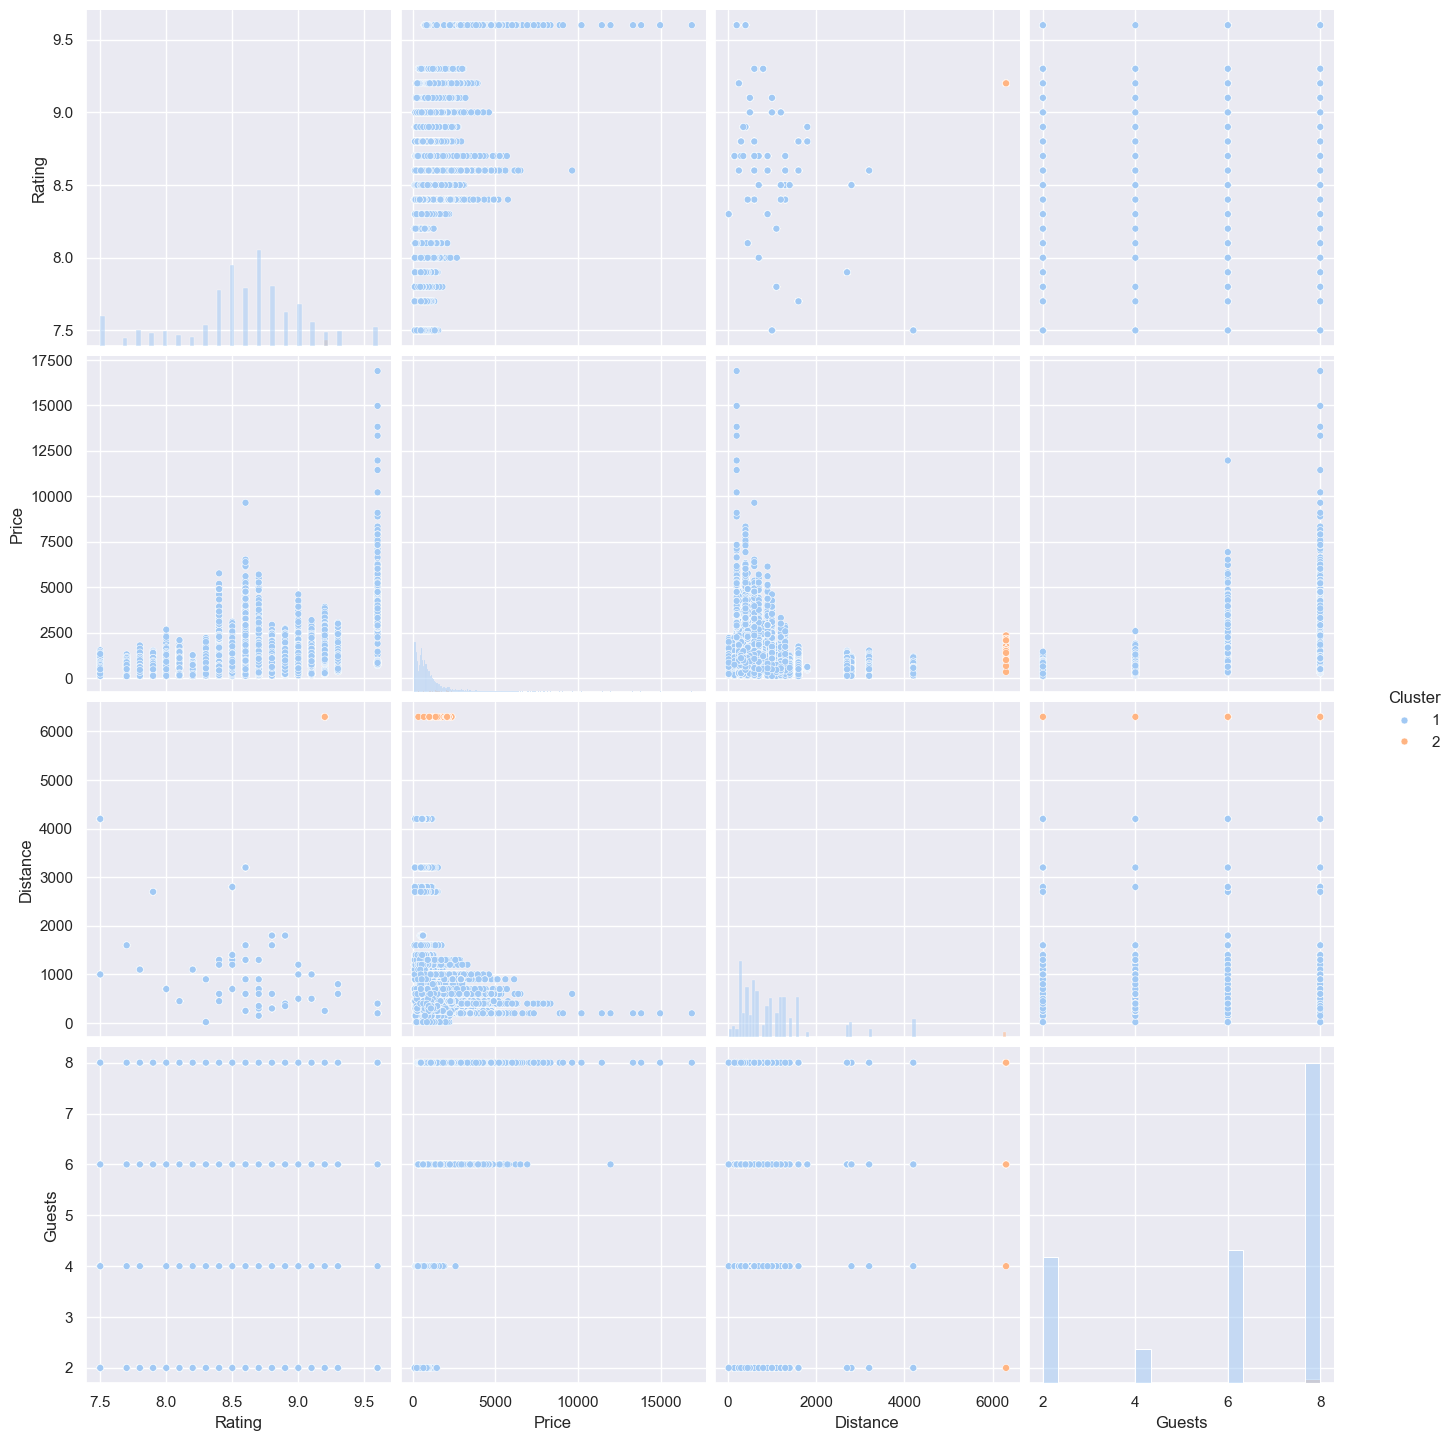

In [198]:
data_desnormalized_dbscan = denorm_from_zero_one(X_dbscan, min_vals, max_vals)
data_desnormalized_dbscan['Cluster'] = clusters_dbscan
gen_pairplot(data_desnormalized_dbscan)

## BIRCH

In [312]:
X_birch = X

print("Ejecutando BIRCH")
b_factor = 25
threshold = 0.1
birch = Birch(branching_factor=b_factor, threshold=threshold)
start_time = time.time()
clusters_birch = birch.fit_predict(X_birch)
end_time = time.time()

n, silh, ch, db = generar_metricas(X_birch, clusters_birch)

results.append({
    "Algorithm": "BIRCH",
    "Number of Clusters": n,
    "Branching factor": b_factor,
    "Threshold": threshold,
    "Execution Time (s)": end_time - start_time,
    "Silhouette Score": silh,
    "Calinski-Harabasz Index": ch,
    "Davies-Bouldin Index": db
})

Ejecutando BIRCH
Silhouette
Calinski_harabasz
Davies_Bouldin


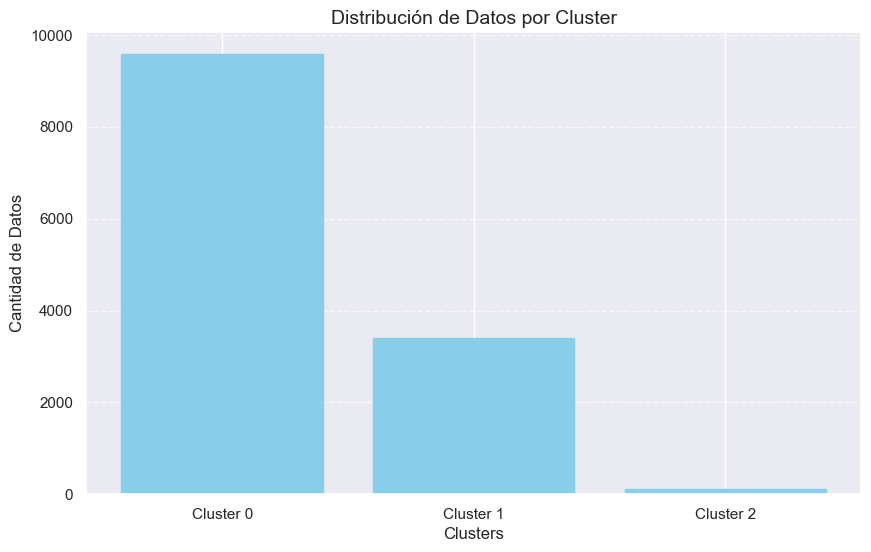

Tamaño de cada cluster:
0:  9582 (73.10%)
1:  3410 (26.01%)
2:   116 ( 0.88%)


In [313]:
barras_clusters(clusters_birch)

clusters_df_birch = pd.DataFrame(clusters_birch,index=X_birch.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters_df_birch['cluster'].value_counts()
size = size.sort_index()

for i,c in enumerate(size):
   print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters_df_birch)))

In [314]:
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

Algorithm  Number of Clusters  Branching factor  Threshold  Execution Time (s)  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
    BIRCH                   3                25        0.1            0.226676          0.570316             10498.832709              0.567145


#### HEATMAP BIRCH

<Figure size 640x480 with 0 Axes>

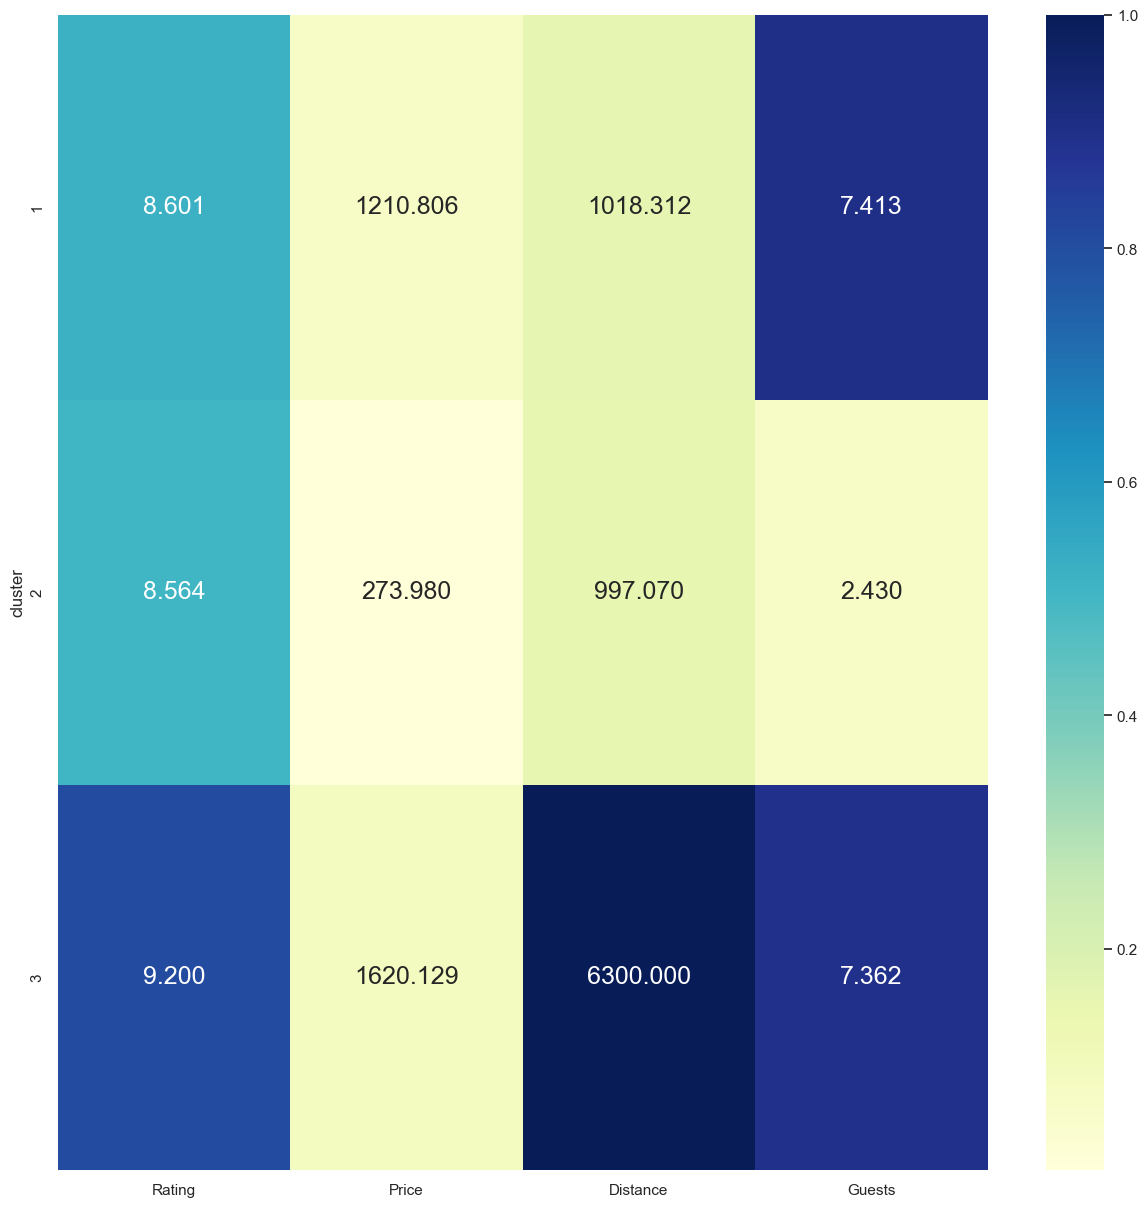

In [318]:
gen_heatmap_2(X_birch, clusters_birch, method="mean")

#### SCATTER MATRIX BIRCH

<Figure size 640x480 with 0 Axes>

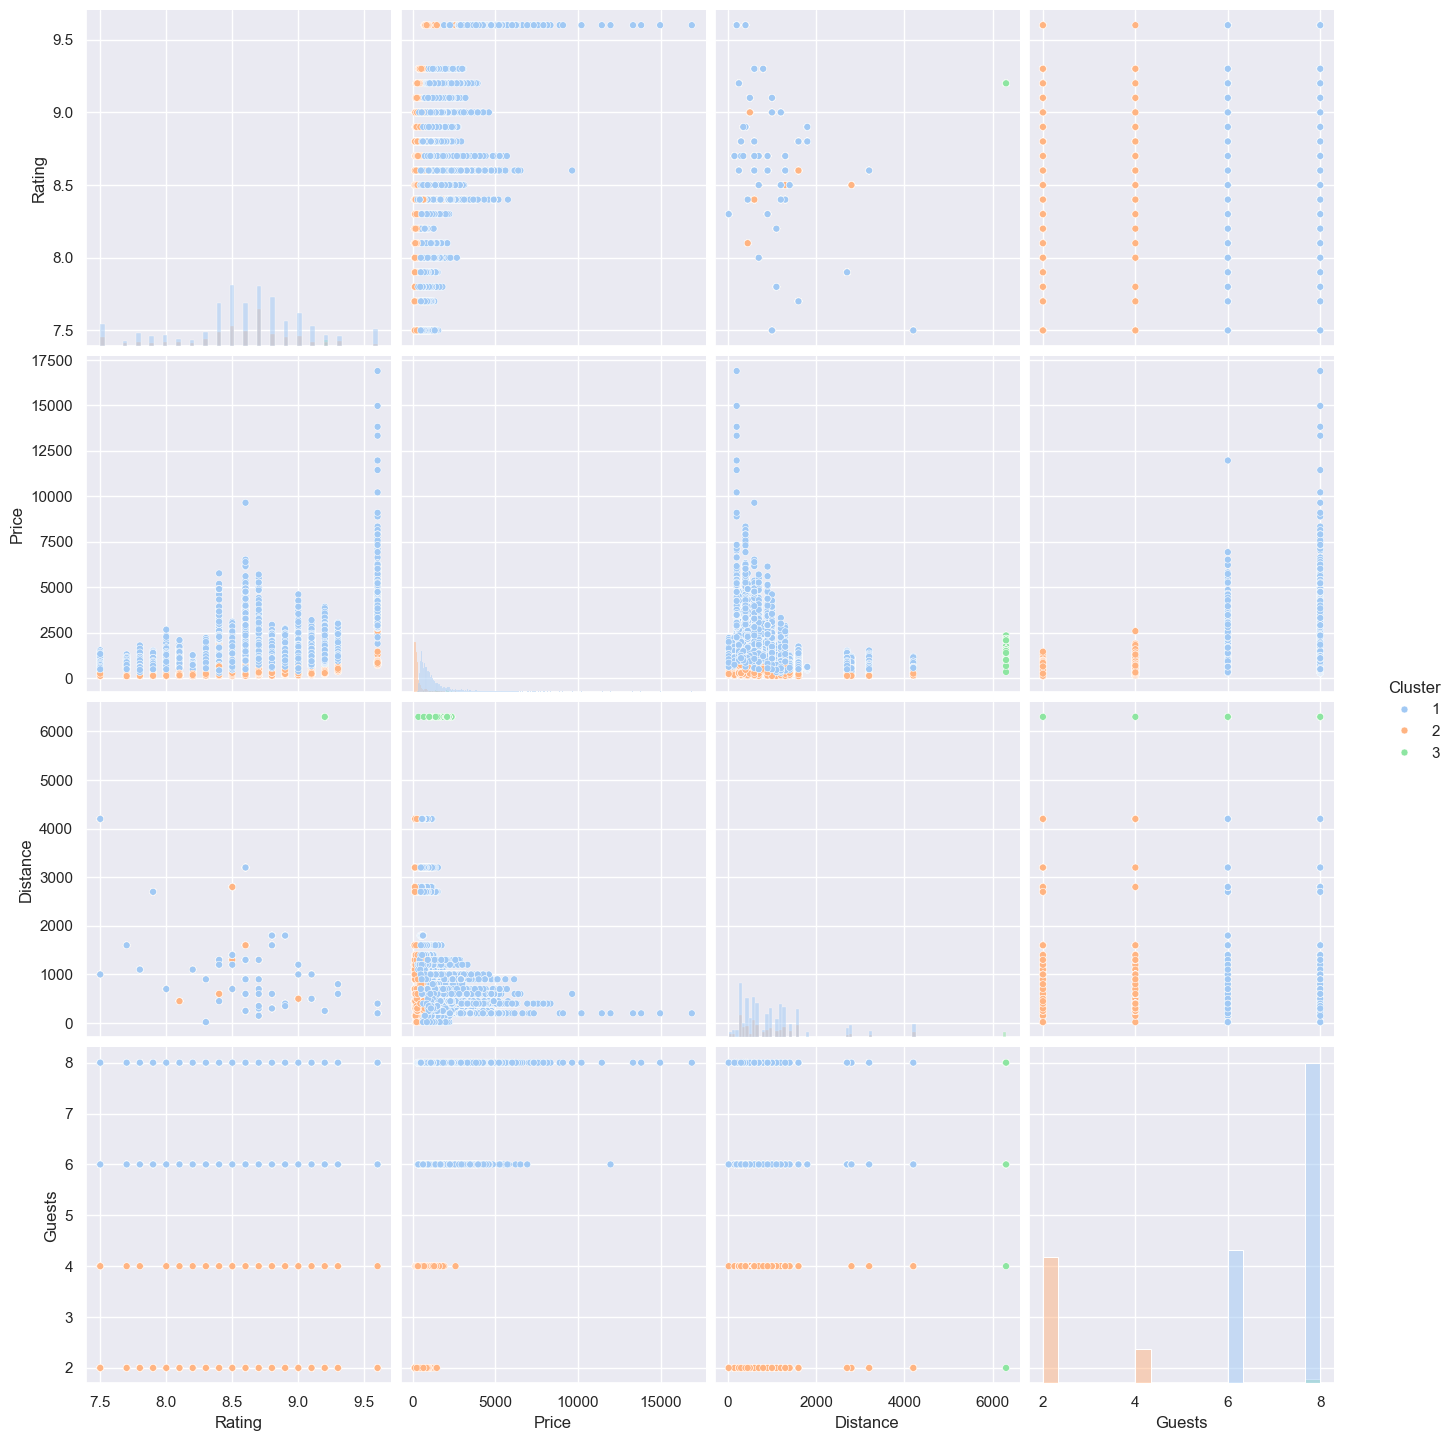

In [315]:
data_desnormalized_birch = denorm_from_zero_one(X_birch, min_vals, max_vals)
data_desnormalized_birch['Cluster'] = clusters_birch
gen_pairplot(data_desnormalized_birch)

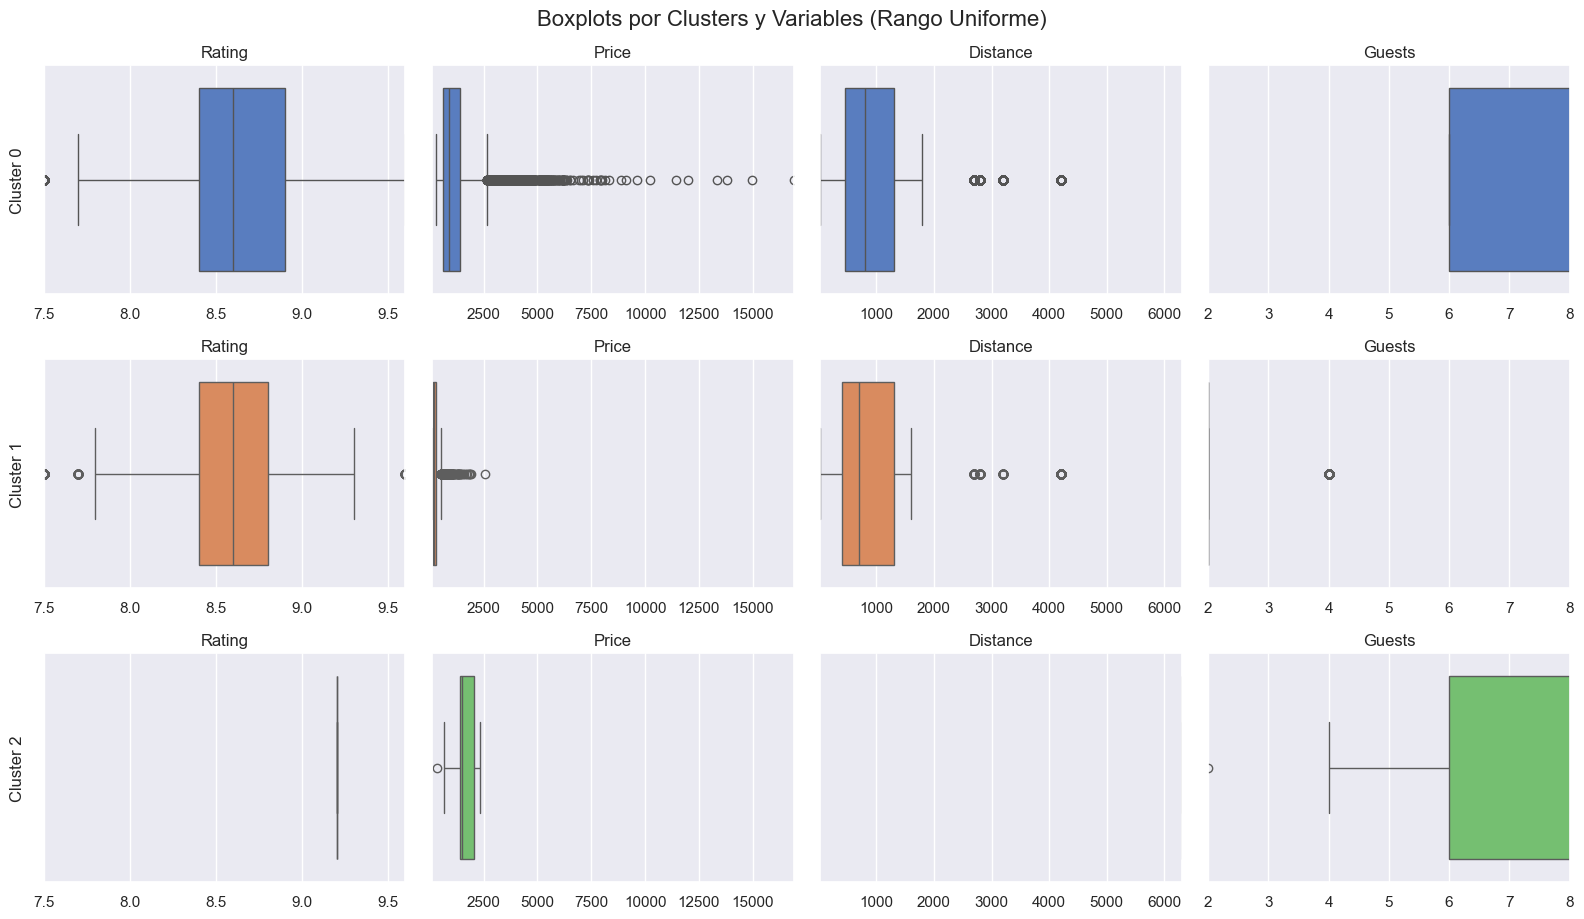

In [316]:
gen_boxplot(data_desnormalized_birch, clusters_birch)

## Algoritmo Jerárquico

In [403]:
X_jerarquico = X.sample(frac=1, random_state=42)

enlace = "single"

print("Ejecutando algoritmo jerárquico")
jerarquico = AgglomerativeClustering(n_clusters=3, linkage="ward", metric="euclidean")
start_time = time.time()
clusters_jerarquico = jerarquico.fit_predict(X_jerarquico)
end_time = time.time()

n, silh, ch, db = generar_metricas(X_jerarquico, clusters_jerarquico)

results.append({
    "Algorithm": "Jerárquico",
    "Number of Clusters": n,
    "Execution Time (s)": end_time - start_time,
    "Silhouette Score": silh,
    "Calinski-Harabasz Index": ch,
    "Davies-Bouldin Index": db
})

Ejecutando algoritmo jerárquico
Silhouette
Calinski_harabasz
Davies_Bouldin


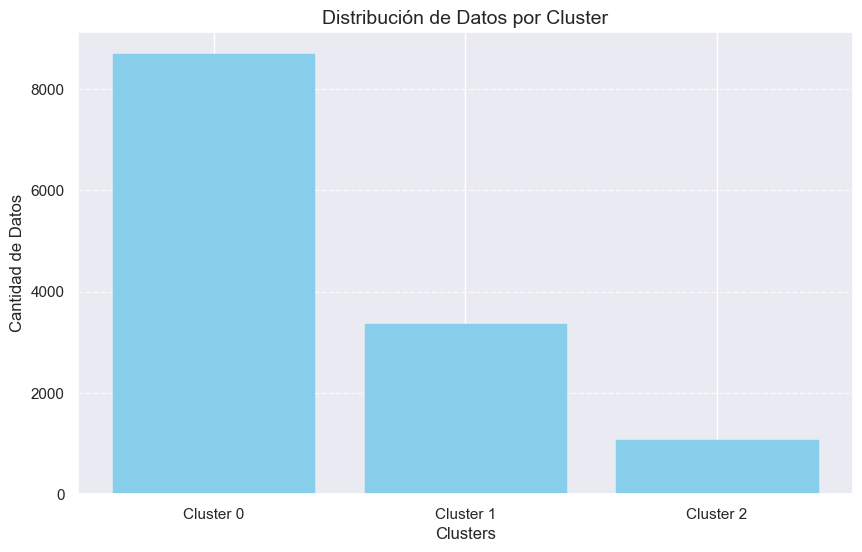

Tamaño de cada cluster:
0:  8688 (66.28%)
1:  3356 (25.60%)
2:  1064 ( 8.12%)


In [408]:
barras_clusters(clusters_jerarquico)

clusters_df_jerarquico = pd.DataFrame(clusters_jerarquico,index=X_jerarquico.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters_df_jerarquico['cluster'].value_counts()
size = size.sort_index()

for i,c in enumerate(size):
   print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters_df_jerarquico)))

In [405]:
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 Algorithm  Number of Clusters  Execution Time (s)  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
Jerárquico                   3            3.131857          0.503047             13770.750907              0.822403
Jerárquico                   5            3.113792          0.427450             11592.328296              0.918597
Jerárquico                   3            3.206575          0.503047             13770.750907              0.822403


#### HEATMAP ENLACE SIMPLE

<Figure size 640x480 with 0 Axes>

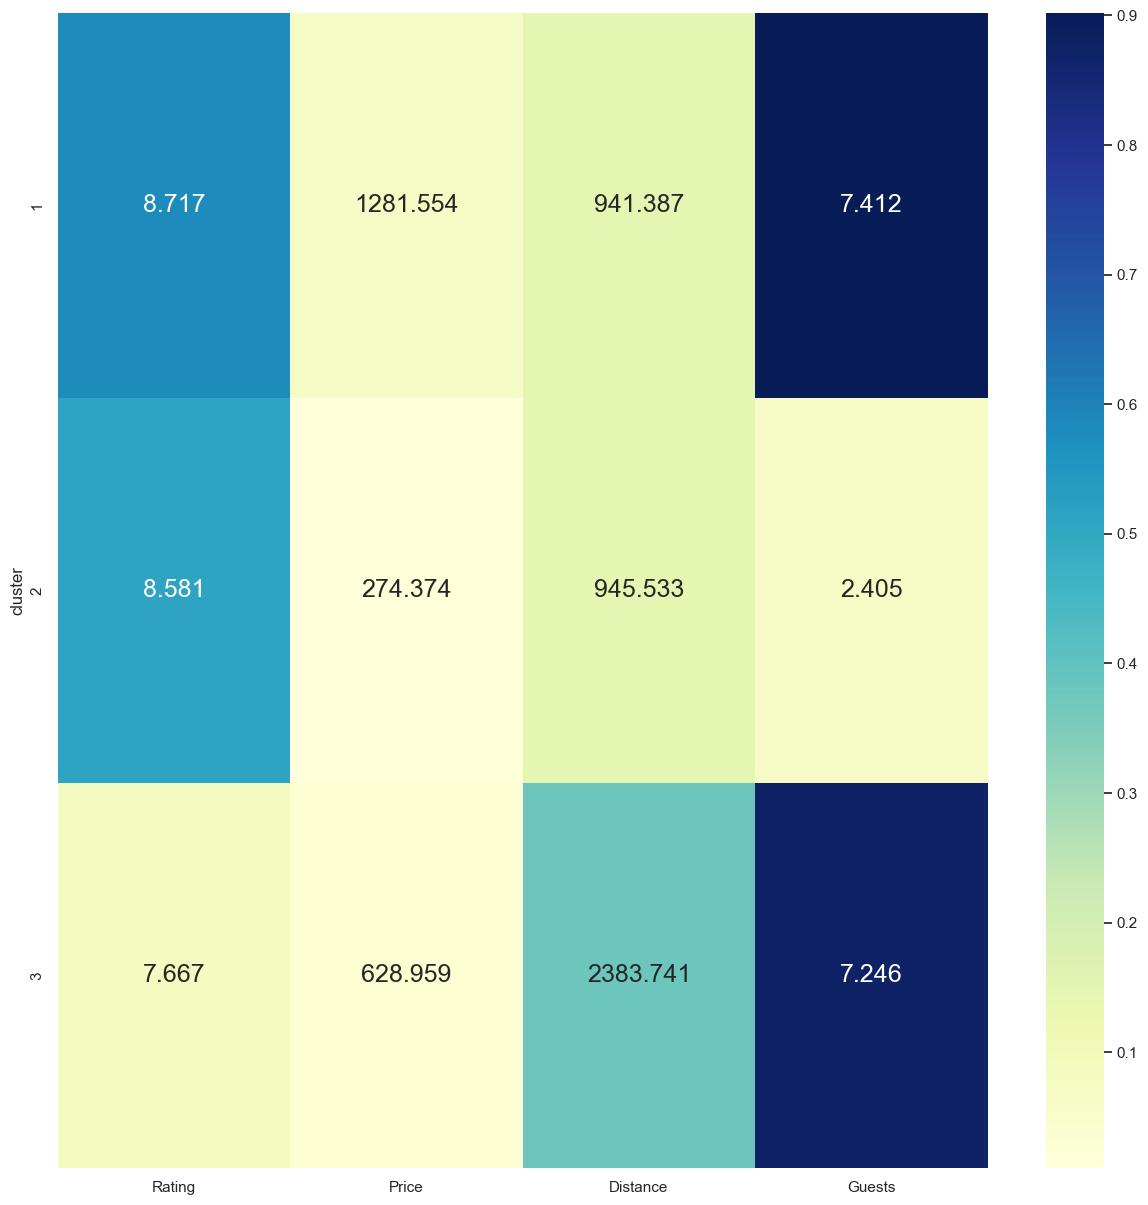

In [404]:
gen_heatmap_2(X_jerarquico, clusters_jerarquico, method="mean")

#### SCATTER MATRIX ENLACE SIMPLE

<Figure size 640x480 with 0 Axes>

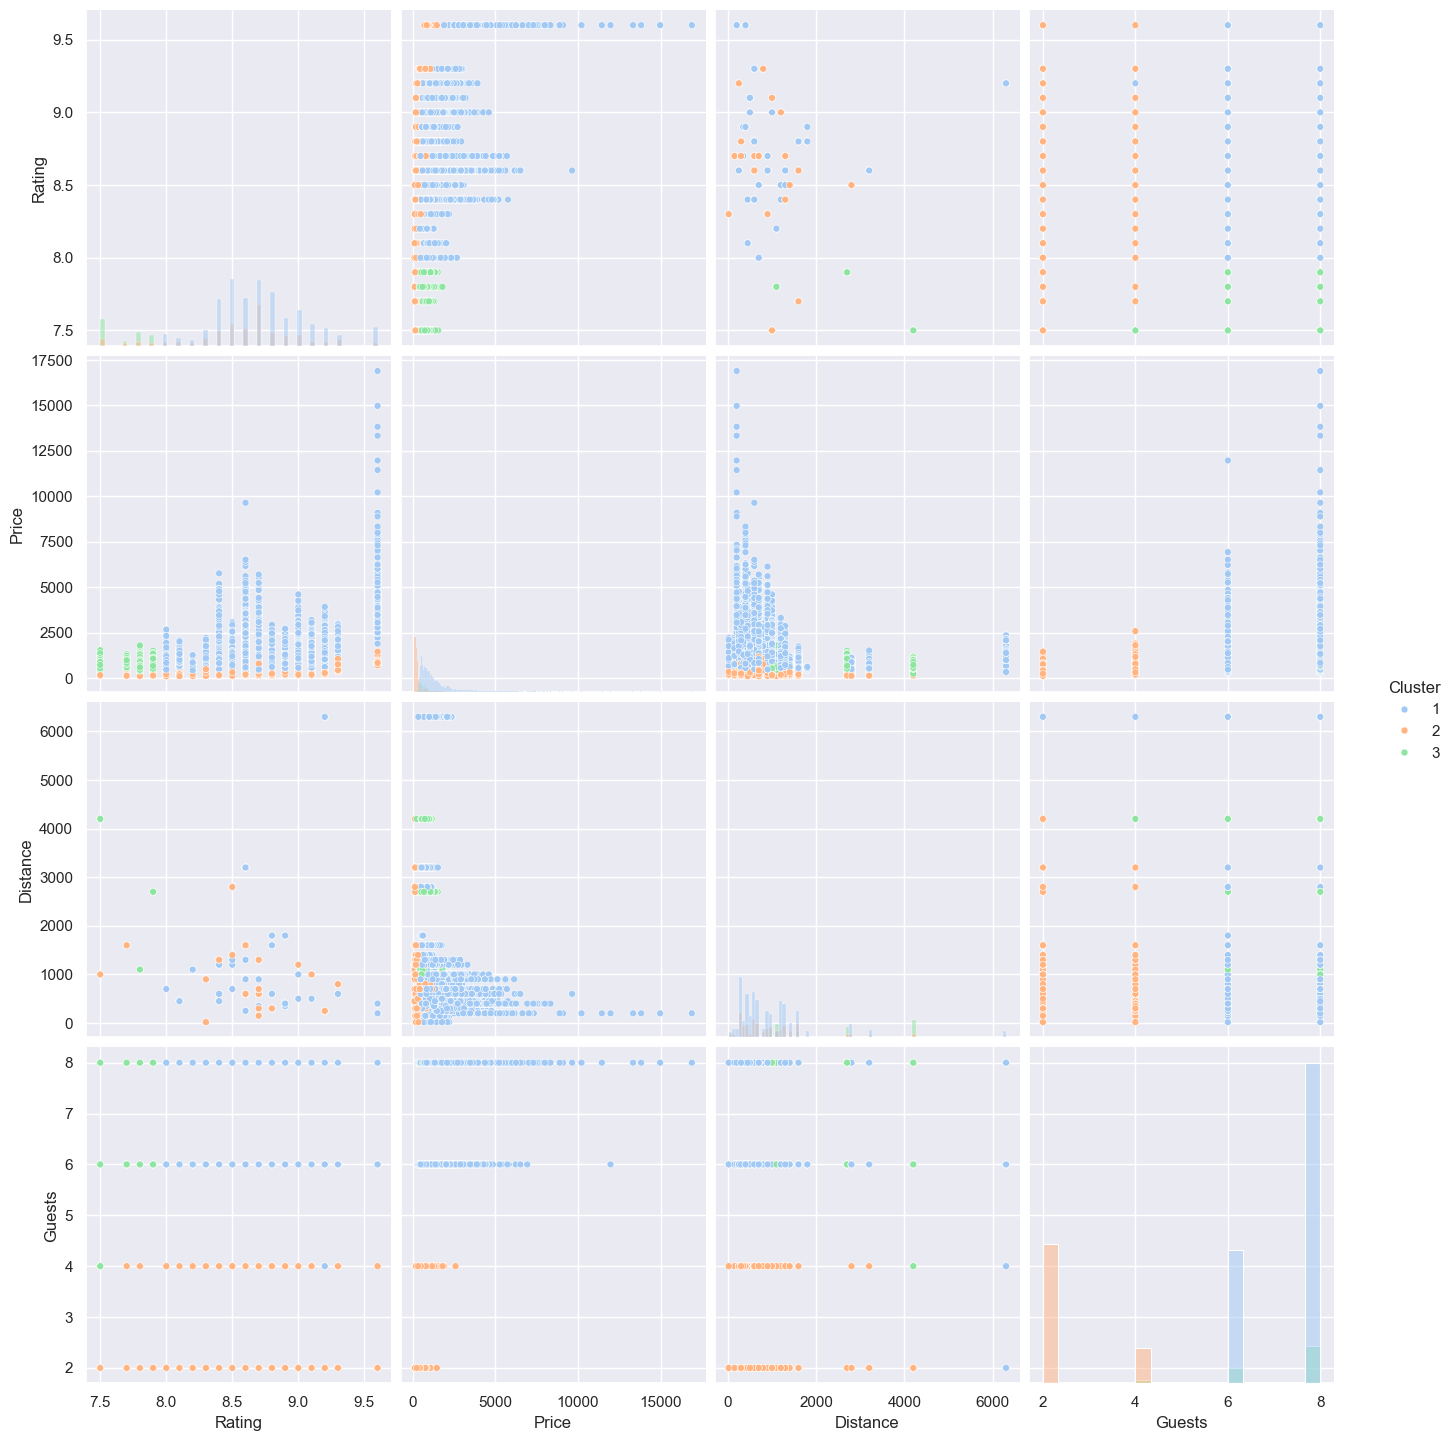

In [406]:
data_desnormalized_jerarquico = denorm_from_zero_one(X_jerarquico, min_vals, max_vals)
data_desnormalized_jerarquico['Cluster'] = clusters_jerarquico
gen_pairplot(data_desnormalized_jerarquico)

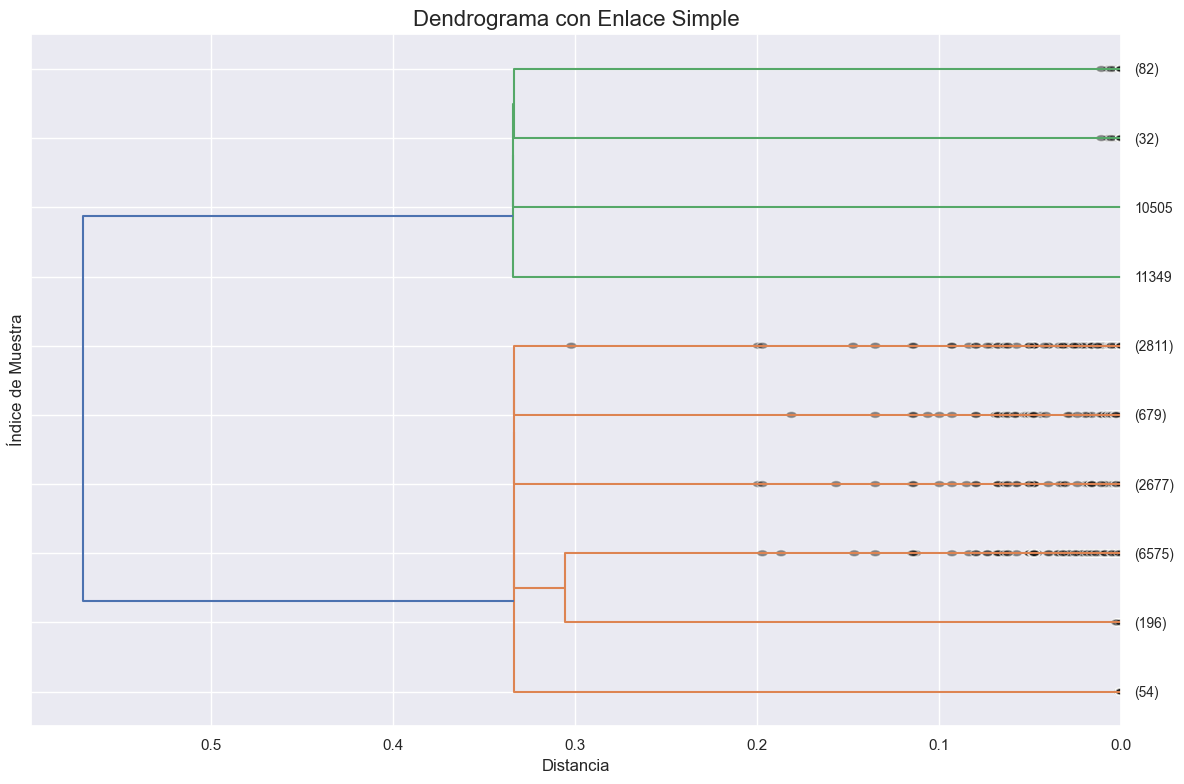

In [407]:
gen_dendogram(X_jerarquico)